## COAST Transect Calculations
Exercise for calcualting temperature, velocities and transport across a transect.

#### Scripting - set paths and import modules
Begin with module imports.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import coast
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import cartopy.feature as cfeature

/home/users/train006/.conda/envs/coast_wrk_shp/lib/python3.10/site-packages/pydap/lib.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
/home/users/train006/.conda/envs/coast_wrk_shp/lib/python3.10/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/home/users/train006/.conda/envs/coast_wrk_shp/lib/python3.10/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap.responses')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#ke

In [2]:
# user directory
uid = "train006"
# analysis year and month
year = 2004
month = 1
# yyyymm format
yyyymm = str(year) + str(month).zfill(2)

Set model paths

In [3]:
path = "/gws/pw/j07/workshop/users/AMM/AMM7_SSB_sample/"
model_path_t = path +  "amm7_1d_{0}01_{0}31_grid_T.nc".format(yyyymm)
model_path_u = path +  "amm7_1d_{0}01_{0}31_grid_U.nc".format(yyyymm)
model_path_v = path +  "amm7_1d_{0}01_{0}31_grid_V.nc".format(yyyymm)
jmmp_path = "/gws/nopw/j04/jmmp/"
domcfg_path = path + "amm7_SSB_mesh_mask.nc"

Set coast config paths

In [4]:
cfg_path = "/home/users/{}/CLASS_workshop/Analysis/AMM/COAST_CFG/".format(uid)
nemo_t_json = cfg_path + "example_nemo_grid_t.json"
nemo_u_json = cfg_path + "example_nemo_grid_u.json"
nemo_v_json = cfg_path + "example_nemo_grid_v.json"
nemo_f_json = cfg_path + "example_nemo_grid_v.json"
cfg_path

'/home/users/train006/CLASS_workshop/Analysis/AMM/COAST_CFG/'

Assign NEMO output to Gridded object to each position on the Awarkara C-Grid. These consist of:

- T-Grid for tracer points at the cell centres
- U-Grid for velocity points on the western cell edge
- V-Grid for velocity points on the southern cell edge
- F-Grid for vorticity/Coriolis points on the south-western cell corners

In [5]:
nemo_t = coast.Gridded(model_path_t, domcfg_path, config=nemo_t_json)
nemo_u = coast.Gridded(model_path_u, domcfg_path, config=nemo_u_json)
nemo_v = coast.Gridded(model_path_v, domcfg_path, config=nemo_v_json)
nemo_f = coast.Gridded(fn_domain=domcfg_path, config=nemo_f_json)

Get transects at T and F points.

In [6]:
lon0, lat0 = 54, -15
lon1, lat1 = 56, -12

tran_t = coast.TransectT(nemo_t, (54, -15), (56, -12))
tran_f = coast.TransectF(nemo_f, (54, -15), (56, -12))

Use COAsT tools to find the lenght of your transect in meters.

In [7]:
dist = coast._utils.general_utils.calculate_haversine_distance(lon0, lon1, lat0, lat1)

Retrive velocites across transect.

In [8]:
tran_f.calc_flow_across_transect(nemo_u, nemo_v)

### Visualise the transect
The transect function find the velocities fields via a nearest neighbour approach and velocities are positioned on the cell faces. This results in a zig-zag transect and we'll plot the path as a demonstration.

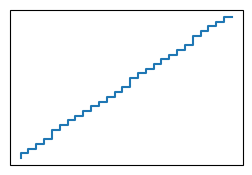

In [9]:
proj = ccrs.PlateCarree()
fig, axs = plt.subplots(1, 1, figsize=(3,3), subplot_kw=dict(projection=proj))
axs.plot(tran_f.data.longitude, tran_f.data.latitude, transform=proj)

We can now show what this transect looks like on the map.

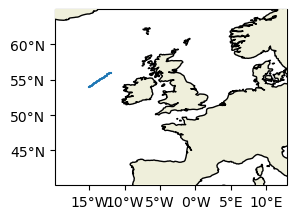

In [10]:
# format axes

# set domain bounds
axs.set_xlim(nemo_t.dataset.longitude.min().values,nemo_t.dataset.longitude.max().values)
axs.set_ylim(nemo_t.dataset.latitude.min().values,nemo_t.dataset.latitude.max().values)
        
# add land
axs.add_feature(cfeature.LAND, zorder=100, edgecolor='k')

# set axis ticks 
axs.set_xticks([-15, -10, -5, 0, 5, 10], crs=ccrs.PlateCarree())
axs.set_yticks([45, 50, 55, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)
axs.yaxis.set_major_formatter(lat_formatter)

fig

### Plotting

#### Plot Time-Mean Temperature Along Extracted Transect

Alias temperature variable.

In [11]:
temp = tran_t.data.temperature

Take time-mean of temperature transect.

In [12]:
temp_mean = temp.mean(dim="t_dim")

Plot time-mean temperature along transect.

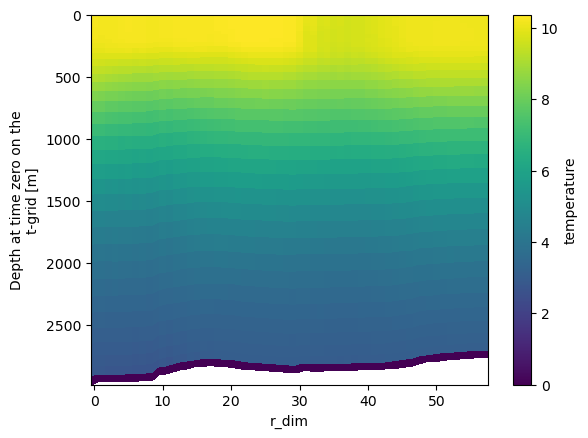

In [13]:
temp_mean.plot.pcolormesh(y="depth_0", yincrease=False)

#### Plot Time-Mean velocities normal to the transect

Alias cross transect velocites.

In [14]:
cross_vel = tran_f.data_cross_tran_flow.normal_velocities

Take time-mean of velocity transect.

In [15]:
cross_vel_mean = cross_vel.mean(dim="t_dim")

Plot time-mean cross transect velocities.

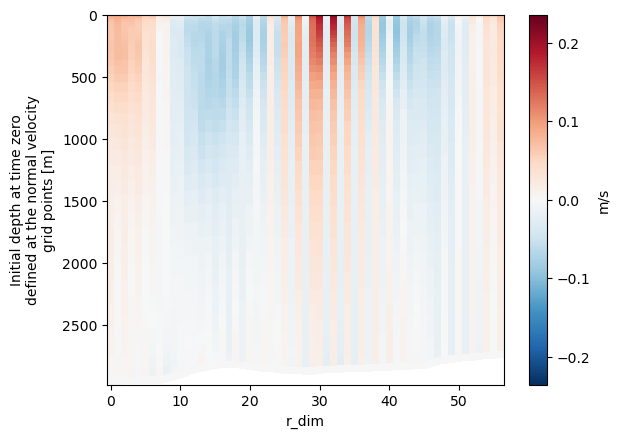

In [16]:
cross_vel_mean.plot.pcolormesh(yincrease=False, y="depth_0", cbar_kwargs={"label": "m/s"})

The above plot looks noisy. This is a result of the zig-zag transect path and not model noise. The purpose of transect transport routine is to indentify the total transport through the line, and the velocity at individual locations will often look unusual.

#### Plot Time-Mean Volume Transport Accoss Transect

Alias transport normal to transect.

In [17]:
cross_transport = tran_f.data_cross_tran_flow.normal_transports

Take time mean.

In [18]:
cross_transport_mean = cross_transport.mean(dim="t_dim")

Plot cross transect transport.

Text(0, 0.5, 'Sv')

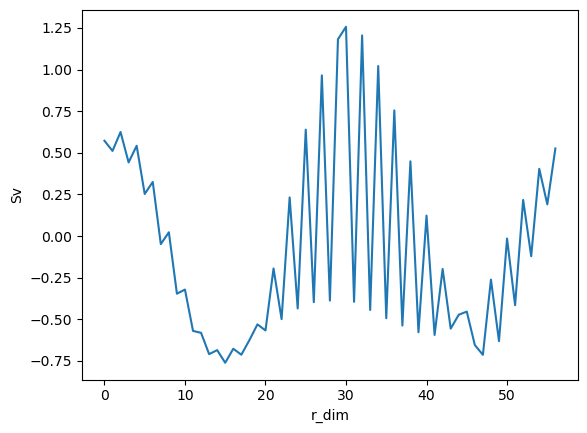

In [19]:
cross_transport_mean.plot()
plt.ylabel("Sv")

The above creates a noisy field due to a zig-zag path taken by the transect. We now find the total transport across the transect over time.

In [20]:
total_transport = tran_f.data_cross_tran_flow.normal_transports.sum("r_dim")

Plot the transport against time.

Text(0, 0.5, 'Sv')

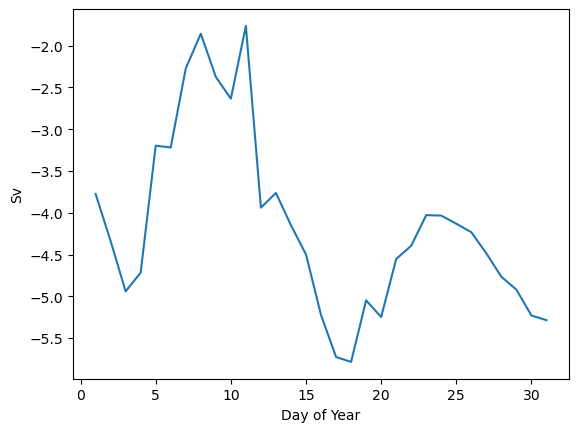

In [21]:
plt.plot(total_transport.time.dt.dayofyear, total_transport)
plt.gca().set_xlabel("Day of Year")
plt.gca().set_ylabel("Sv")